**QUESTION 1**

Avg intensity using histogram: 103.30500158906722
Actual avg intensity: 103.30500158906722


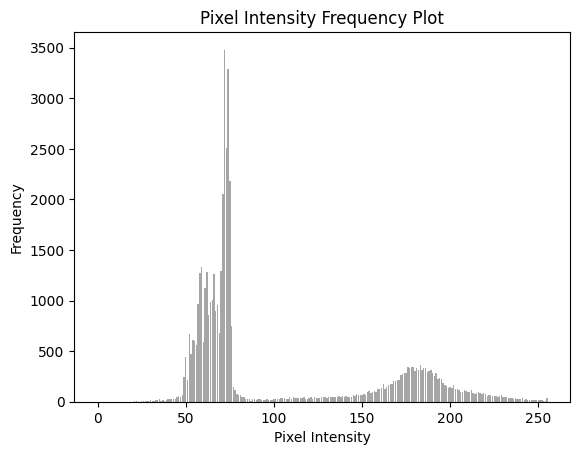

In [9]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

image = io.imread('coins.png')

pixel_values = image.flatten()

histrogram = np.zeros((256))

for i in range(pixel_values.size):
    histrogram[pixel_values[i]] += 1

plt.figure()
plt.bar(np.arange(256), histrogram, color='gray', alpha=0.7)
plt.title('Pixel Intensity Frequency Plot')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

avg_intensity_histogram = np.sum(np.arange(256) * histrogram) / pixel_values.size

avg_act_intensity = np.mean(pixel_values)

print(f"Avg intensity using histogram: {avg_intensity_histogram}")
print(f"Actual avg intensity: {avg_act_intensity}")


**QUESTION 2**

<ipython-input-10-1069ed90027a>:44: RuntimeWarning: invalid value encountered in divide
  cum_u0 = cum_means / sum_w0


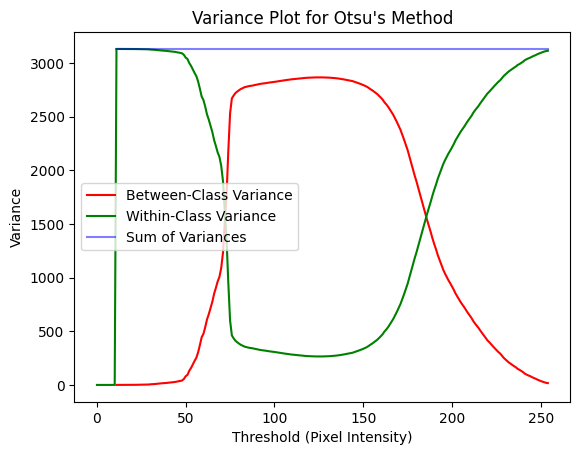

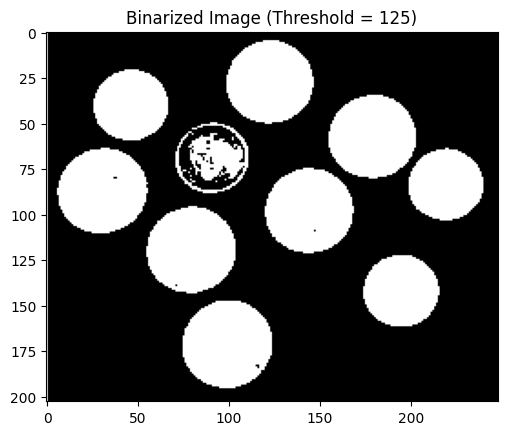

In [10]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

image = io.imread('coins.png')

pixel_values = image.flatten()

histogram = np.zeros((256))
for i in range(pixel_values.size):
    histogram[pixel_values[i]] += 1

hist_nor = histogram / pixel_values.size
pix = np.arange(256)
best_sig = float('inf')
best_thresh = 0
track_sig = np.zeros(256)
# WITH-IN CLASS VARIENCE
for i in range(256):
    w0 = np.sum(hist_nor[:i+1])
    w1 = 1 - w0

    if w0 == 0 or w1 == 0:
        continue

    u0 = np.sum(pix[:i+1] * hist_nor[:i+1]) / w0
    u1 = np.sum(pix[i+1:] * hist_nor[i+1:]) / w1

    sig0 = np.sum(((pix[:i+1] - u0) ** 2) * hist_nor[:i+1]) / w0
    sig1 = np.sum(((pix[i+1:] - u1) ** 2) * hist_nor[i+1:]) / w1

    sig_w = w0 * sig0 + w1 * sig1

    if sig_w < best_sig:
        best_sig = sig_w
        best_thresh = i

    track_sig[i] = sig_w
#BETWEEN CLASS VARIENCE USING CUMMULATIVE SUM APPROACH
sum_w0 = np.cumsum(hist_nor)
sum_w1 = 1 - sum_w0
cum_means = np.cumsum(pix * hist_nor)
u_t = cum_means[-1]
cum_u0 = cum_means / sum_w0
cum_u1 = (u_t - cum_means) / sum_w1
sig_b = sum_w0 * sum_w1 * ((cum_u0 - cum_u1) ** 2)

plt.figure()
plt.plot(np.arange(0, 255), sig_b[0:255], label='Between-Class Variance', color='r')
plt.plot(np.arange(0, 255), track_sig[0:255], label='Within-Class Variance', color='g')
plt.plot(np.arange(0, 255), sig_b[0:255] + track_sig[0:255], label='Sum of Variances', color='b', alpha=0.5)
plt.xlabel('Threshold (Pixel Intensity)')
plt.ylabel('Variance')
plt.title('Variance Plot for Otsu\'s Method')
plt.legend()
plt.show()

binary_image = np.zeros(image.shape)
binary_image[image <= best_thresh] = 0
binary_image[image > best_thresh] = 255

plt.figure()
plt.imshow(binary_image, cmap='gray')
plt.title(f'Binarized Image (Threshold = {best_thresh})')
plt.show()


**QUESTION 3**

<ipython-input-56-4a284a442eb8>:19: RuntimeWarning: invalid value encountered in divide
  cum_u0 = cum_means / sum_w0
<ipython-input-56-4a284a442eb8>:20: RuntimeWarning: invalid value encountered in divide
  cum_u1 = (u_t - cum_means) / sum_w1


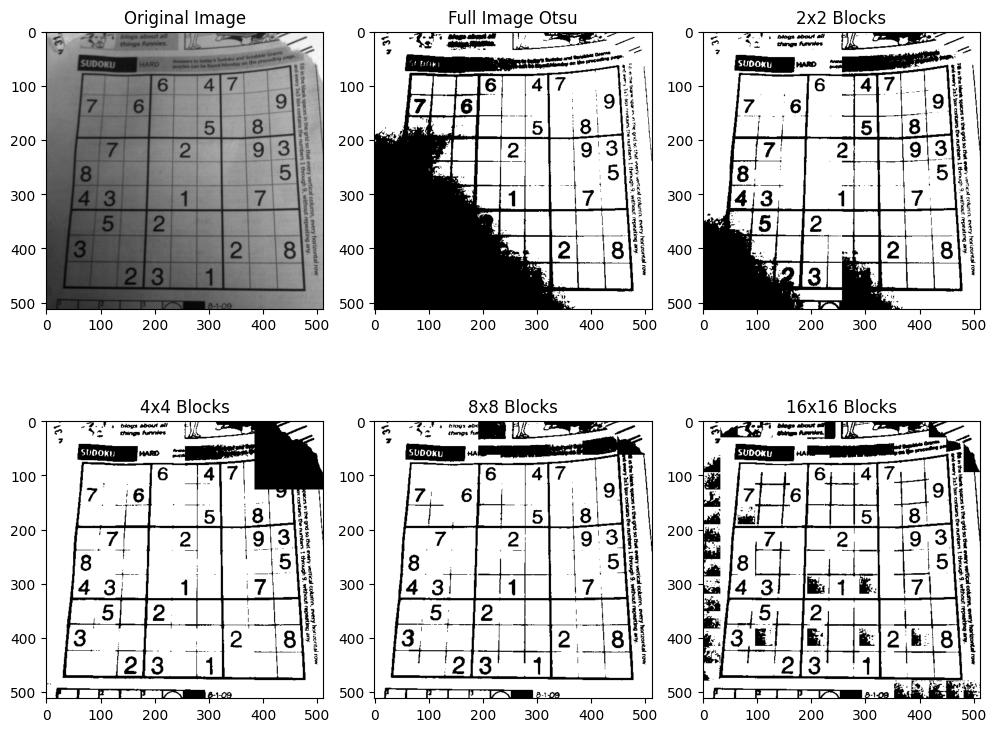

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def otsu_threshold(image):
    """Apply Otsu's thresholding to an image block."""
    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    hist_nor = hist / hist.sum()

    pixel_values = np.arange(256)
    best_sig = float('inf')
    best_thresh = 0

    sum_w0 = np.cumsum(hist_nor)
    sum_w1 = 1 - sum_w0

    cum_means = np.cumsum(pixel_values * hist_nor)
    u_t = cum_means[-1]
    cum_u0 = cum_means / sum_w0
    cum_u1 = (u_t - cum_means) / sum_w1

    valid = (sum_w0 > 0) & (sum_w1 > 0)

    sig_b = np.zeros(256)
    sig_b[valid] = sum_w0[valid] * sum_w1[valid] * ((cum_u0[valid] - cum_u1[valid]) ** 2)

    best_thresh = np.argmax(sig_b)

    return best_thresh

def apply_otsu_binarization(image, N):
    h, w = image.shape
    block_h, block_w = h // N, w // N

    binarized_image = np.zeros_like(image)

    for i in range(N):
        for j in range(N):
            block = image[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            thresh = otsu_threshold(block)
            _, binarized_block = cv2.threshold(block, thresh, 255, cv2.THRESH_BINARY)
            binarized_image[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w] = binarized_block

    return binarized_image


image = cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE)

_, full_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

adaptive_2x2 = apply_otsu_binarization(image, 2)
adaptive_4x4 = apply_otsu_binarization(image, 4)
adaptive_8x8 = apply_otsu_binarization(image, 8)
adaptive_16x16 = apply_otsu_binarization(image, 16)

plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(full_otsu, cmap='gray')
plt.title('Full Image Otsu')

plt.subplot(2, 3, 3)
plt.imshow(adaptive_2x2, cmap='gray')
plt.title('2x2 Blocks')

plt.subplot(2, 3, 4)
plt.imshow(adaptive_4x4, cmap='gray')
plt.title('4x4 Blocks')

plt.subplot(2, 3, 5)
plt.imshow(adaptive_8x8, cmap='gray')
plt.title('8x8 Blocks')

plt.subplot(2, 3, 6)
plt.imshow(adaptive_16x16, cmap='gray')
plt.title('16x16 Blocks')

plt.tight_layout()
plt.show()


**QUESTION 4**

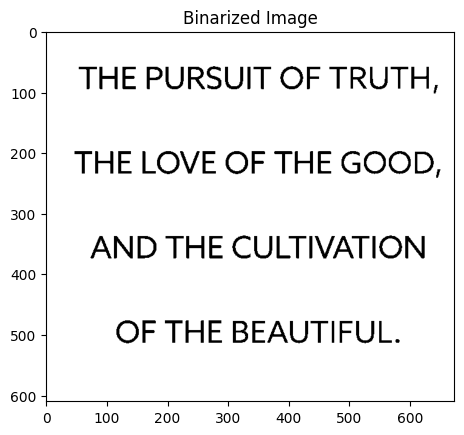

total charcter identified: 68
total character after excluding punctuation : 64


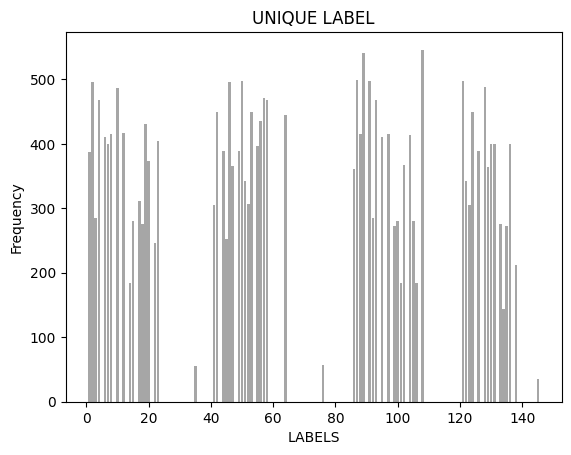

In [62]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
quote = io.imread('quote.png')
h,w=quote.shape

def binarize(image):
    thresh=otsu_threshold(image)
    binary_image=np.zeros(image.shape)
    binary_image[image<=thresh] = 0
    binary_image[image>thresh]=255
    return binary_image
bin_quote=binarize(quote)
plt.figure()
plt.imshow(bin_quote,cmap='gray')
plt.title('Binarized Image')
plt.show()
label_region=np.zeros((h,w))
c=1
"""
first we go row-wise and check top column 3 neigbours(i-1,j-1;i-1,j:i-1,j+1) and
 right neigbour(i,j-1).
"""
for i in range(1,h-1):
    for j in range(1,w-1):
        if(bin_quote[i,j]==0):# if current pixel is zero then it say we have to look its neighbours
          n1=bin_quote[i-1][j-1:j+2]
          n_l = bin_quote[i][j-1]
          l_region=label_region[i-1][j-1:j+2] # neighbours of the labeling array(label_region) vs neighbours of the origial image(bin_quote)
          l_region_l = label_region[i][j-1]
          if(np.all(n1==255) and n_l==255): # if all the neigbours are 255 it say it is the start of new component
              label_region[i,j]=c
              c=c+1      #if increase the component

          else:   # then if we find any multiple differnt label are neigbhours to the current pixel then it means all those labes belongs to same label

            l_min=[]

            if np.any(n1 == 0):
              l_min.extend(l_region[l_region>0])

            if n_l == 0:
              l_min.append(l_region_l)

            a = np.array(l_min)  # we take the min label and assign that label to all the multiple labels
            mini=np.min(a)
            label_region[i,j]=mini
            if(np.any(l_region != min) or l_region_l != min):
              label_region[np.isin(label_region,l_min)]=mini
unique_labels=np.unique(label_region).size
print(f"total charcter identified: {unique_labels}")
#to remove punctuvation marks
l_values = label_region.flatten()
l_values = l_values.astype(int)
max_value = np.max(l_values)
h = np.zeros(max_value+1, dtype=int)
for i in range(l_values.size):    # we calculate the histrogram for differnt labels and then remove those labels which are above 600 and below 100
    h[l_values[i]] +=1
remove_labels=h[h<100]
plt.figure()
x=np.arange(max_value+1)
plt.bar(x[1:], h[1:], color='gray', alpha=0.7)
plt.title('UNIQUE LABEL')
plt.xlabel('LABELS')
plt.ylabel('Frequency')
# total character are unique labels - punctuation marks -background
total_characters=unique_labels-np.unique(remove_labels).size
print(f"total character after excluding punctuation : {total_characters}")

